In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 引入数据集
match_data_path = './Wimbledon_featured_matches.csv'
match_data = pd.read_csv(match_data_path)
match_data

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,112.0,W,NCTL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:39:58,5,10,330,2,2,5,...,0,0,0,38.620,50.971,11,123.0,C,NCTL,D
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:40:43,5,10,331,2,2,5,...,0,0,0,17.533,27.766,5,114.0,W,NCTL,ND
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:20,5,10,332,2,2,5,...,0,0,0,10.882,18.328,4,124.0,W,NCTL,D
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:52,5,10,333,2,2,5,...,0,0,0,7.893,10.537,1,130.0,C,NCTL,D


In [5]:
# 数据预处理

# Convert `elapsed_time` to timedelta
match_data['elapsed_time_td'] = pd.to_timedelta(match_data['elapsed_time'])

# 处理数据得到elased_time_td Calculate the time difference in seconds within each match_id group
match_data['time_diff'] = match_data.groupby('match_id')['elapsed_time_td'].diff().dt.total_seconds()

# Fill NaN values with the first elapsed_time value in each group, converted to seconds
match_data['time_diff'] = match_data.groupby('match_id')['time_diff'].fillna(
    match_data['elapsed_time_td'].dt.total_seconds()
)

# Show the updated dataframe to verify changes
match_data[['match_id', 'elapsed_time', 'time_diff']].head()


,match_id,elapsed_time,time_diff
0,2023-wimbledon-1301,00:00:00,0.0
1,2023-wimbledon-1301,00:00:38,38.0
2,2023-wimbledon-1301,00:01:01,23.0
3,2023-wimbledon-1301,00:01:31,30.0
4,2023-wimbledon-1301,00:02:21,50.0


In [21]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])[['p1_points_won', 'p2_points_won']].apply(lambda x: x.values.tolist()).reset_index(name='points_won_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['points_won_list'].tolist()

# Convert the 'p1_points_won', 'p2_points_won' values into their differences
points_diff_lists = [[p1 - p2 for p1, p2 in match] for match in points_won_lists]

# Display the first few elements to verify the transformation
points_diff_lists[:5]



[[-1, 0, -1, 0, 1, 0, 1, 0, 1, 2],
 [1, 2, 3, 2, 1, 2, 1, 0],
 [1, 2, 1, 2, 3],
 [2, 1, 0, -1],
 [0, 1, 2, 1, 0, -1, 0, 1]]

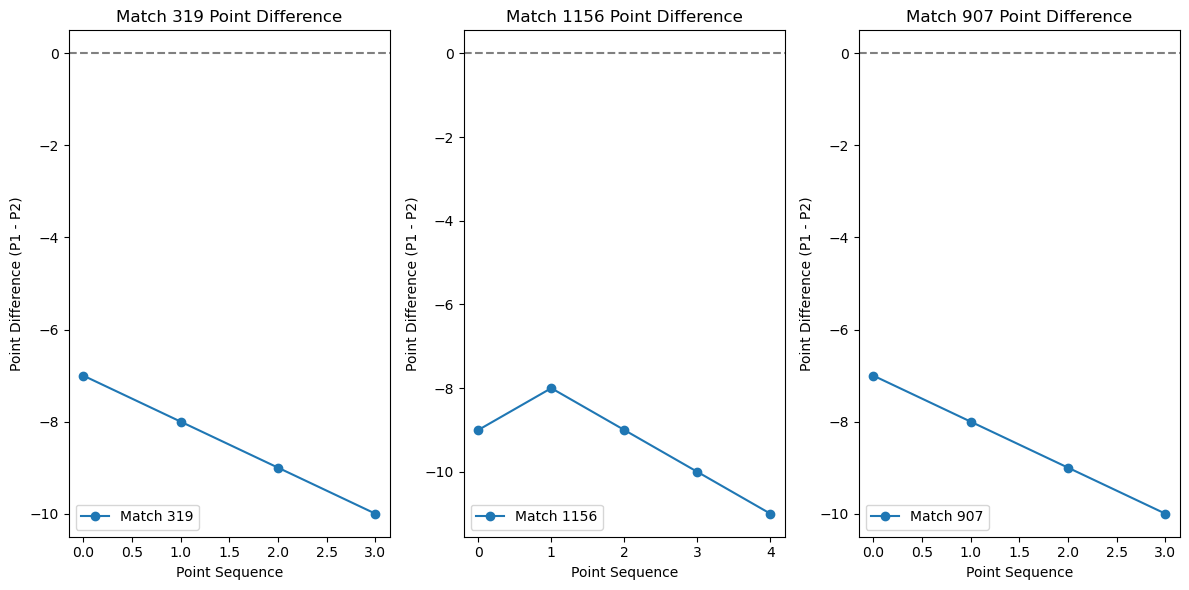

In [25]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_diff_lists), size=3, replace=False)
selected_matches_diffs = [points_diff_lists[i] for i in selected_indices]

# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Point Difference (P1 - P2)')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])[['p1_ace', 'p2_ace']].apply(lambda x: x.values.tolist()).reset_index(name='ace_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['ace_list'].tolist()

# Display the first few elements to verify the transformation

points_won_lists[:5]


[[[0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [1, 0],
  [0, 0],
  [1, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[1, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 1], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]

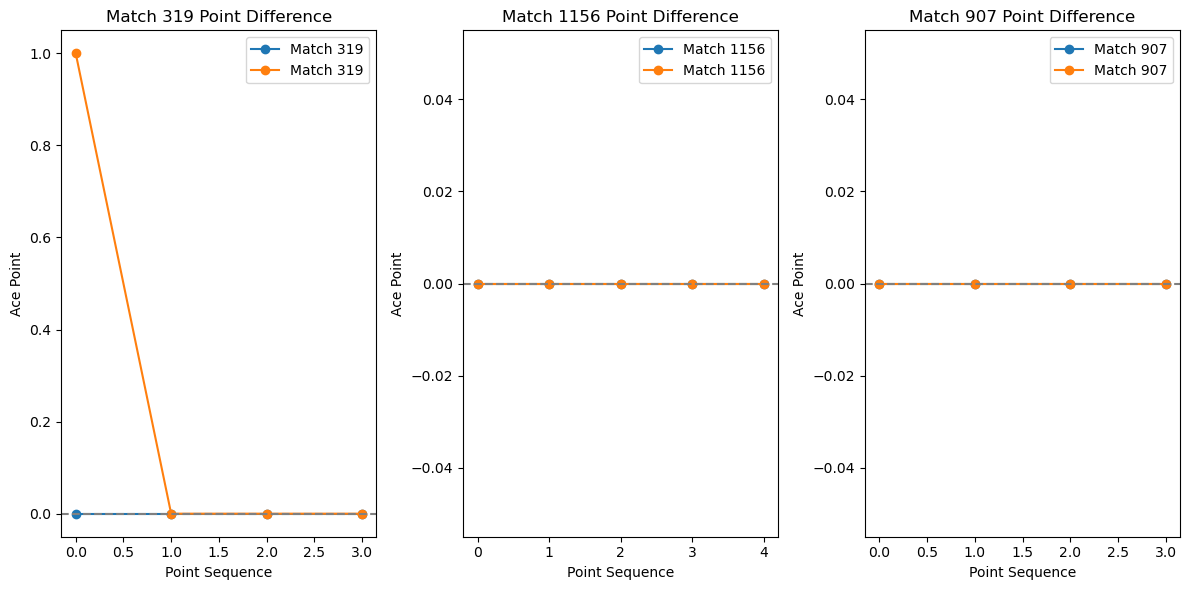

In [29]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
selected_matches_diffs = [points_won_lists[i] for i in selected_indices]

# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Ace Point')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()
#本代码由DS数模团队原创，倒卖必究，正版（会更新错误）群：172466373
plt.tight_layout()
plt.show()


In [30]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])[['p1_winner', 'p2_winner']].apply(lambda x: x.values.tolist()).reset_index(name='winner_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['winner_list'].tolist()

# Display the first few elements to verify the transformation

points_won_lists[:5]


[[[0, 0],
  [0, 0],
  [0, 0],
  [1, 0],
  [1, 0],
  [0, 0],
  [1, 0],
  [0, 1],
  [0, 0],
  [0, 0]],
 [[0, 1], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 1]],
 [[1, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 1], [0, 1]],
 [[1, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]

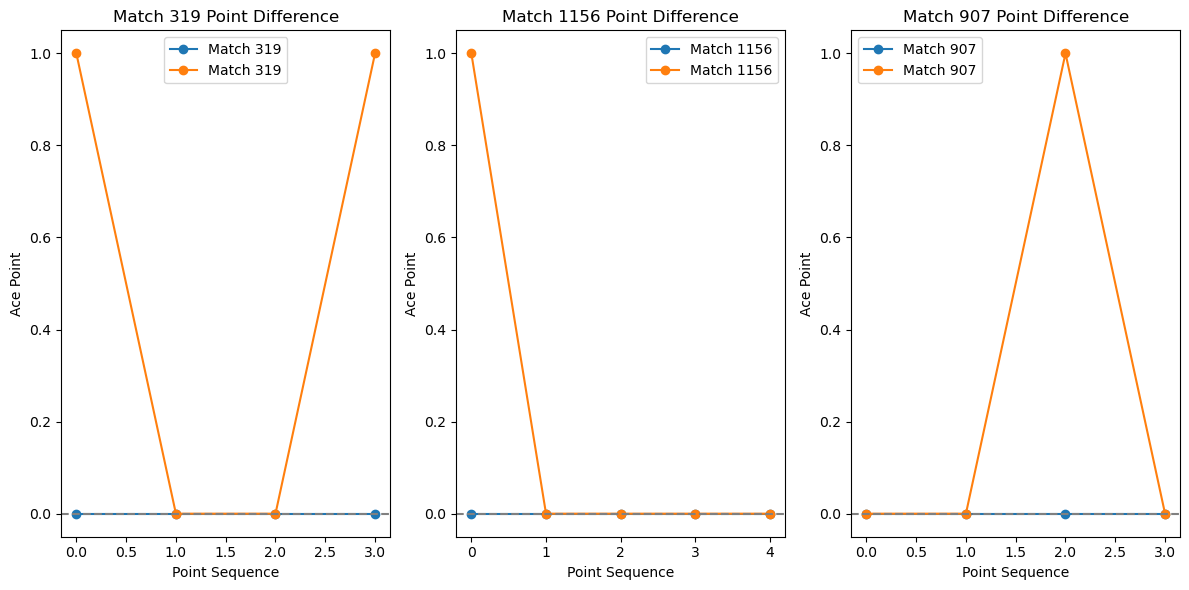

In [31]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
selected_matches_diffs = [points_won_lists[i] for i in selected_indices]

# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Winner Point')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()


In [32]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])['time_diff'].apply(lambda x: x.values.tolist()).reset_index(name='time_diff_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['time_diff_list'].tolist()

# Display the first few elements to verify the transformation

points_won_lists[:5]


[[0.0, 38.0, 23.0, 30.0, 50.0, 29.0, 43.0, 28.0, 47.0, 44.0],
 [93.0, 23.0, 38.0, 35.0, 30.0, 26.0, 43.0, 25.0],
 [39.0, 23.0, 30.0, 27.0, 42.0],
 [125.0, 44.0, 32.0, 21.0],
 [41.0, 36.0, 25.0, 30.0, 43.0, 52.0, 32.0, 52.0]]

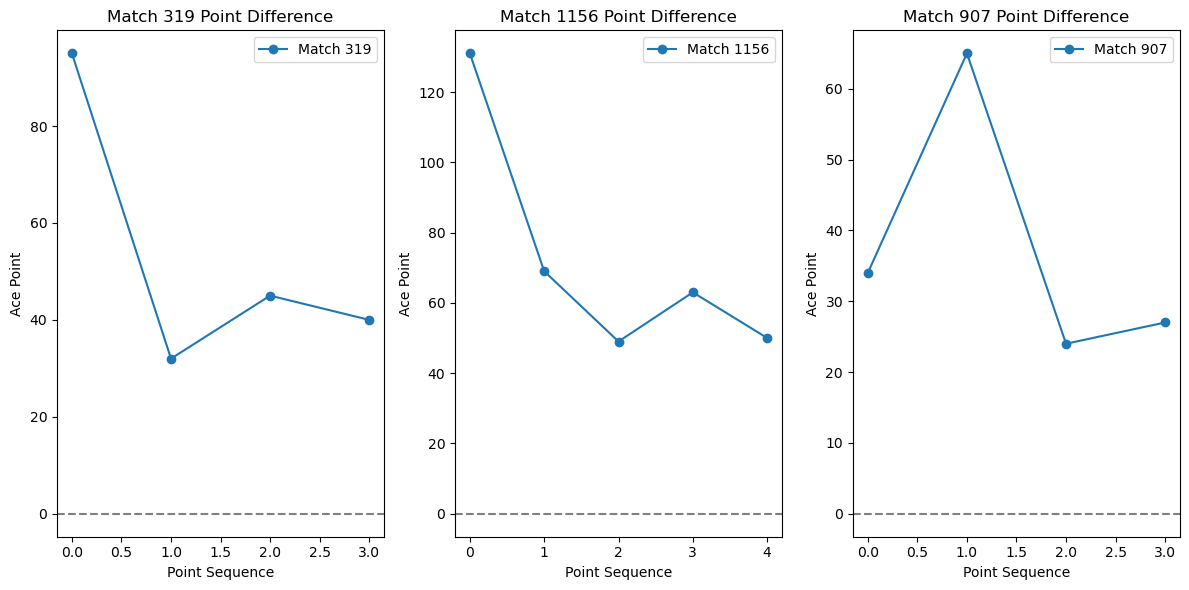

In [33]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
selected_matches_diffs = [points_won_lists[i] for i in selected_indices]
#本代码由DS数模团队原创，倒卖必究，正版（会更新错误）群：172466373
# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Time')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])['p1_unf_err','p2_unf_err'].apply(lambda x: x.values.tolist()).reset_index(name='unf_err_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['unf_err_list'].tolist()

# Display the first few elements to verify the transformation
#本代码由DS数模团队原创，倒卖必究，正版（会更新错误）群：172466373
points_won_lists[:5]


C:\Users\admin\AppData\Local\Temp\ipykernel_8388\4256323620.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])['p1_unf_err','p2_unf_err'].apply(lambda x: x.values.tolist()).reset_index(name='unf_err_list')


[[[1, 0],
  [0, 0],
  [1, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 [[0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 1], [0, 0]],
 [[1, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [1, 0], [0, 0], [1, 0], [0, 0], [0, 0]]]

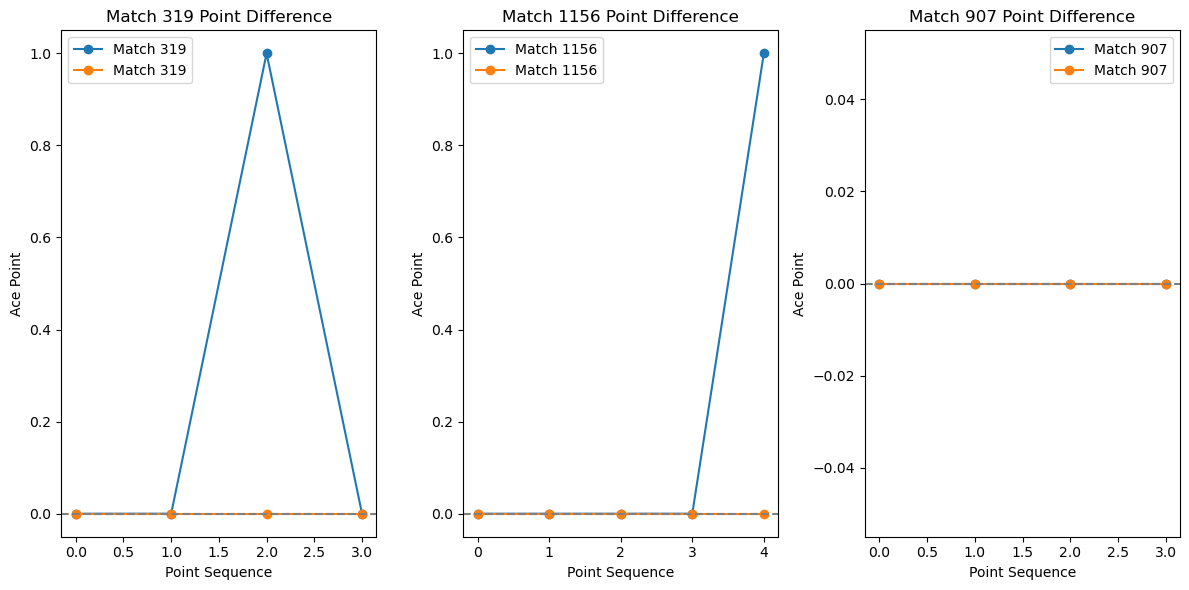

In [35]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
selected_matches_diffs = [points_won_lists[i] for i in selected_indices]

# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Unf Error')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()


In [36]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])['point_victor'].apply(lambda x: x.values.tolist()).reset_index(name='victor_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['victor_list'].tolist()
#本代码由DS数模团队原创，倒卖必究，正版（会更新错误）群：172466373
# Display the first few elements to verify the transformation

points_won_lists[:5]


[[2, 1, 2, 1, 1, 2, 1, 2, 1, 1],
 [2, 1, 1, 2, 2, 1, 2, 2],
 [1, 1, 2, 1, 1],
 [2, 2, 2, 2],
 [1, 1, 1, 2, 2, 2, 1, 1]]

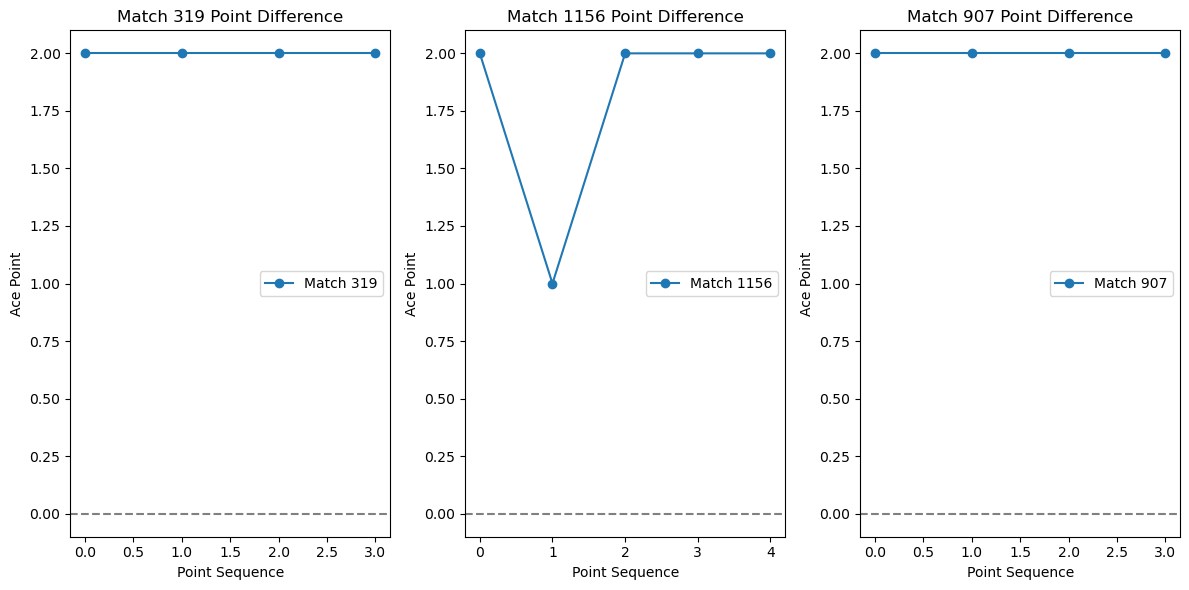

In [37]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
selected_matches_diffs = [points_won_lists[i] for i in selected_indices]

# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Winning Player')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()


In [38]:
match_data['presure_t'] = 0.5*(match_data['p1_sets']-match_data['p2_sets'])+0.1*(match_data['p1_games']-match_data['p2_games'])
match_data['presure_t'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: presure_t, dtype: float64

In [39]:
# Group by ['match_id', 'set_no', 'game_no'] and collect the corresponding 'p1_points_won', 'p2_points_won' into lists
grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])['presure_t'].apply(lambda x: x.values.tolist()).reset_index(name='t_list')

# Convert the grouped data to a list of lists as requested
points_won_lists = grouped_data['t_list'].tolist()

# Display the first few elements to verify the transformation

points_won_lists[:5]


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.1, 0.1, 0.1, 0.1],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

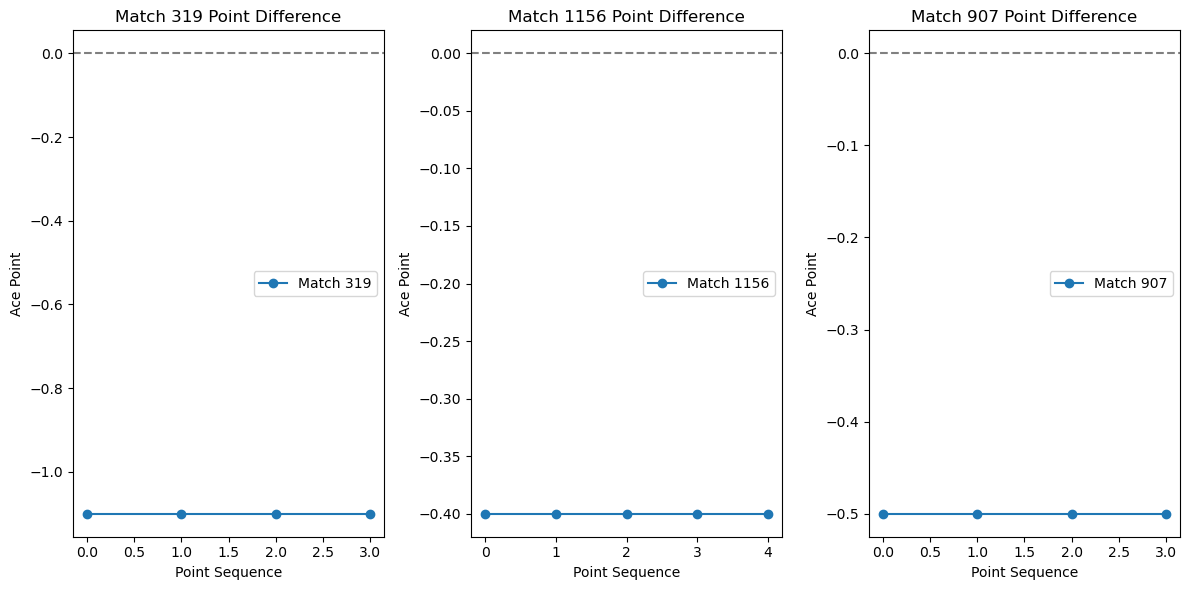

In [40]:
# Randomly select a few matches for visualization
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
selected_matches_diffs = [points_won_lists[i] for i in selected_indices]
#本代码由DS数模团队原创，倒卖必究，正版（会更新错误）群：172466373
# Visualization
plt.figure(figsize=(12, 6))

for i, match_diffs in enumerate(selected_matches_diffs, start=1):
    plt.subplot(1, 3, i)
    plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
    plt.xlabel('Point Sequence')
    plt.ylabel('Presure Point')
    plt.title(f'Match {selected_indices[i-1]} Point Difference')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()


In [43]:
def Calculate__Performance(df):
    df['p1'] = df['time_diff']/40+df['p1_sets']*0.5+df['p1_games']*0.1+df['p1_ace']+df['p1_winner']*0.5-df['p1_unf_err']*0.5
    df['p2'] = df['time_diff']/40+df['p2_sets']*0.5+df['p2_games']*0.1+df['p2_ace']+df['p2_winner']*0.5-df['p2_unf_err']*0.5
    
    for index, round in df.iterrows():
        if index==0:
            if round['point_victor']==1:
                round['p1'] += 0.5
            else:
                round['p2'] += 0.5
            continue
            
        if round['point_victor']==1:
            if df[index-1]['point_victor']==1:
                round['p1'] += 0.5*1.2
            else:
                round['p1'] += 0.5
        else:
            if df[index-1]['point_victor']==1:
                round['p1'] += 0.5
            else:
                round['p1'] += 0.5*1.2
    
    return df['p1'],df['p2']

p1_scores, p2_scores = Calculate__Performance(match_data)
p1_scores, p2_scores

KeyError: 0

In [69]:
def Calculate_Performance(df):
    df['p1'] = df['time_diff']/100 + df['p1_sets']*0.5 + df['p1_games']*0.1 + df['p1_ace'] + df['p1_winner']*0.5 - df['p1_unf_err']*0.5
    df['p2'] = df['time_diff']/100 + df['p2_sets']*0.5 + df['p2_games']*0.1 + df['p2_ace'] + df['p2_winner']*0.5 - df['p2_unf_err']*0.5
    #本代码由DS数模团队原创，倒卖必究，正版（会更新错误）群：172466373
    for index in range(len(df)):
        if index == 0:
            if df.at[index, 'point_victor'] == 1:
                df.at[index, 'p1'] += 0.5
            else:
                df.at[index, 'p2'] += 0.5
            continue
            
        if df.at[index, 'point_victor'] == 1:
            if df.at[index-1, 'point_victor'] == 1:
                df.at[index, 'p1'] += 0.5 * 1.2
            else:
                df.at[index, 'p1'] += 0.5
        else:
            if df.at[index-1, 'point_victor'] == 1:
                df.at[index, 'p2'] += 0.5
            else:
                df.at[index, 'p2'] += 0.5 * 1.2
    
    return df['p1'], df['p2']

# 调用函数并获取结果
p1_scores, p2_scores = Calculate_Performance(match_data[match_data['match_id']=='2023-wimbledon-1301'])
p1_scores, p2_scores

C:\Users\admin\AppData\Local\Temp\ipykernel_8388\1598811438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p1'] = df['time_diff']/100 + df['p1_sets']*0.5 + df['p1_games']*0.1 + df['p1_ace'] + df['p1_winner']*0.5 - df['p1_unf_err']*0.5
C:\Users\admin\AppData\Local\Temp\ipykernel_8388\1598811438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p2'] = df['time_diff']/100 + df['p2_sets']*0.5 + df['p2_games']*0.1 + df['p2_ace'] + df['p2_winner']*0.5 - df['p2_unf_err']*0.5


(0     -0.50
 1      0.88
 2     -0.27
 3      1.30
 4      2.60
        ... 
 295    2.15
 296    1.96
 297    2.71
 298    2.52
 299    2.57
 Name: p1, Length: 300, dtype: float64,
 0      0.50
 1      0.38
 2      0.73
 3      0.30
 4      0.50
        ... 
 295    2.05
 296    2.46
 297    1.61
 298    1.32
 299    1.37
 Name: p2, Length: 300, dtype: float64)

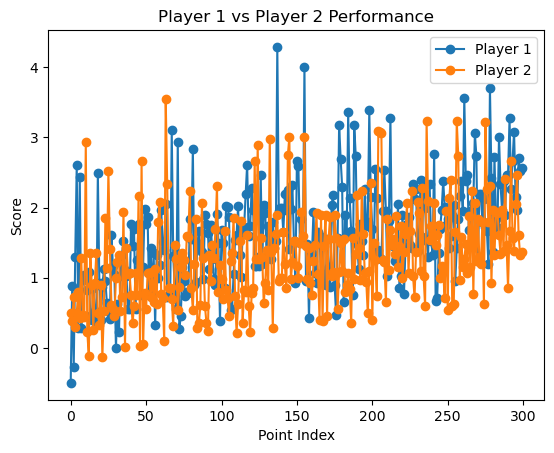

In [70]:
# 假设p1_scores和p2_scores是您计算得到的分数
# 创建一个与分数长度相同的索引列表，以用作X轴
index = list(range(len(p1_scores)))

# 绘制p1和p2的折线图
plt.plot(index, p1_scores, label='Player 1', linestyle='-', marker='o')
plt.plot(index, p2_scores, label='Player 2', linestyle='-', marker='o')

# 添加标签和标题
plt.xlabel('Point Index')
plt.ylabel('Score')
plt.title('Player 1 vs Player 2 Performance')

# 添加图例
plt.legend()

# 显示图形
plt.show()


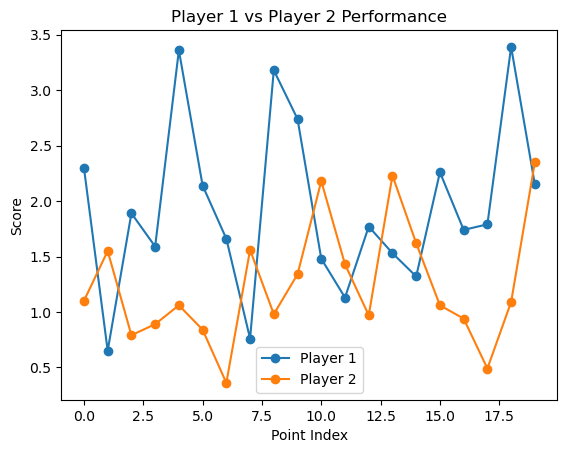

In [74]:
# 假设p1_scores和p2_scores是您计算得到的分数
# 创建一个与分数长度相同的索引列表，以用作X轴
index = list(range(len(p1_scores[180:200])))

# 绘制p1和p2的折线图
plt.plot(index, p1_scores[180:200], label='Player 1', linestyle='-', marker='o')
plt.plot(index, p2_scores[180:200], label='Player 2', linestyle='-', marker='o')

# 添加标签和标题
plt.xlabel('Point Index')
plt.ylabel('Score')
plt.title('Player 1 vs Player 2 Performance')

# 添加图例
plt.legend()

# 显示图形
plt.show()
